In [18]:
import neptune
from neptune.types import File
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
run = neptune.init_run(
    project="MaleLab/440MI",
    api_token="",
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/MaleLab/440MI/e/MI-2


In [20]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [21]:
X = data.drop("quality", axis=1)
y = data["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [22]:
model = GradientBoostingRegressor(random_state=42)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.2],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=2
)


In [23]:
grid_search.fit(X_train, y_train)

# Log best parameters and metrics to Neptune
run["best/parameters"] = grid_search.best_params_
run["best/cv_score"] = grid_search.best_score_

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print(f"Test MSE: {mse:.3f}")
print(f"Test R²: {r2:.3f}")

# Log metrics to Neptune
run["test/mse"] = mse
run["test/r2"] = r2


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(

[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=200; total time=   0.6s


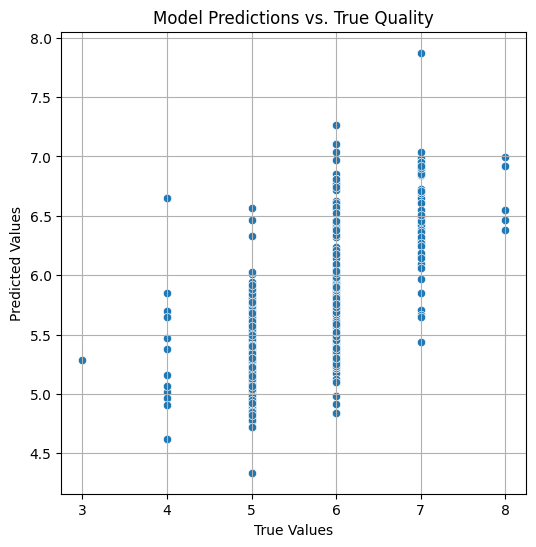

In [24]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Model Predictions vs. True Quality")
plt.grid(True)
#plt.show()

run["plots/predictions_vs_true"].upload(File.as_image(plt.gcf()))


In [25]:
import joblib

model_path = "best_gb_model.pkl"
joblib.dump(best_model, model_path)

run["artifacts/model"].upload(model_path)
print(f"✅ Best model saved as {model_path}")


✅ Best model saved as best_gb_model.pkl


In [26]:
run.stop()


[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 9 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/MaleLab/440MI/e/MI-2/metadata
